In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles



from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = True
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Setup

In [94]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic



# Define outut folder for plot data
plot_data_dir = f"plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"
feature_set = ["dimu_pt", "mu0_ip3d", "mu1_ip3d"]


train_samesign = False


# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

data_prefix = f"{project_id}_{particle_type}{train_data_id}_{jet_id}"

In [95]:
bin_percent = {8: 2.3, 12: 1.5, 16: 1.1}

In [96]:
with open(f"{plot_data_dir}{data_prefix}_SR_SB.pickle", "rb") as file:
    SR, SB = pickle.load(file)
    SB_left, SB_right = SB
    SR_left, SR_right = SR

print(f"SR: {SR_left}, {SR_right}")
print(f"SB: {SB_left}, {SB_right}")

SR: 9.0, 10.6
SB: 7.8, 14.0


# Cut Histograms

In [97]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# Color conversion filters
def rgb_to_gray(color):
    """Convert an RGB color to grayscale using luminosity."""
    return 0.2989 * color[0] + 0.5870 * color[1] + 0.1140 * color[2]

def rgb_to_rg_colorblind(color):
    """Convert an RGB color to a simulated red-green colorblind palette."""
    # Transformation matrix for RG colorblind simulation
    # Approximation for protanopia or deuteranopia
    colorblind_matrix = np.array([
        [0.567, 0.433, 0.0],
        [0.558, 0.442, 0.0],
        [0.0, 0.242, 0.758]
    ])
    return np.clip(np.dot(colorblind_matrix, color), 0, 1)

def apply_color_filter(color, filter_function):
    """General function to apply a filter to a color."""
    if isinstance(color, str):  # Convert named color to RGB
        color = mcolors.to_rgb(color)
    filtered_color = filter_function(color)
    if np.isscalar(filtered_color):  # Grayscale outputs a single value
        return (filtered_color, filtered_color, filtered_color)
    return tuple(filtered_color)

# Plot element updates
def update_lines(ax, filter_function):
    for line in ax.get_lines():
        color = line.get_color()
        new_color = apply_color_filter(color, filter_function)
        line.set_color(new_color)

def update_patches(ax, filter_function):
    for patch in ax.patches:
        face_color = patch.get_facecolor()
        edge_color = patch.get_edgecolor()
        new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
        new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
        patch.set_facecolor(new_face_color)
        patch.set_edgecolor(new_edge_color)

def update_collections(ax, filter_function):
    for collection in ax.collections:
        face_colors = collection.get_facecolor()
        edge_colors = collection.get_edgecolor()
        if len(face_colors) > 0:
            new_face_colors = [
                apply_color_filter(fc[:3], filter_function) + (fc[3],) for fc in face_colors
            ]
            collection.set_facecolor(new_face_colors)
        if len(edge_colors) > 0:
            new_edge_colors = [
                apply_color_filter(ec[:3], filter_function) + (ec[3],) for ec in edge_colors
            ]
            collection.set_edgecolor(new_edge_colors)

def update_legend(ax, filter_function):
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_color("black")  # Keep legend text black
        for handle in legend.legendHandles:
            if isinstance(handle, mpatches.Patch):  # Patches (e.g., histograms)
                face_color = handle.get_facecolor()
                edge_color = handle.get_edgecolor()
                new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
                new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
                handle.set_facecolor(new_face_color)
                handle.set_edgecolor(new_edge_color)
            elif hasattr(handle, 'get_color'):  # Lines
                color = handle.get_color()
                new_color = apply_color_filter(color, filter_function)
                handle.set_color(new_color)

def apply_color_filter_to_plot(ax, filter_function):
    """Apply a color filter to all elements of a plot."""
    update_lines(ax, filter_function)
    update_patches(ax, filter_function)
    update_collections(ax, filter_function)
    update_legend(ax, filter_function)
    # Axes ticks and spines
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    return ax

In [105]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)


def plot_histograms_with_fits(save_data, SB_left, SR_left, SR_right, SB_right, title = None, upsilon_lines = True, colors = None, alphas = None, line_0 = None):
    
    fpr_thresholds = save_data["fpr_thresholds"]
    fit_type = save_data["fit_type"]
    num_bins_SR = save_data["num_bins_SR"]
    popts = save_data["popts"]
    pcovs = save_data["pcovs"]
    significances = save_data["significances"]
    filtered_masses = save_data["filtered_masses"]
    y_vals = save_data["y_vals"]


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


    fig, ax = newplot("column", width = 8, height = 4)


    if colors is None:
        colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
    if alphas is None:
        alphas = np.linspace(1, 0.5, len(fpr_thresholds))[::-1]

    # colors = [((i) * np.power(i, 0.25), 0 , (1-i) * np.power(i, 0.25)) for i in np.linspace(0, 1, len(fpr_thresholds))]

    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses_t = filtered_masses[t]
        popt = popts[t]
        pcov = pcovs[t]
        total_events = len(filtered_masses_t)
        significance = significances[t]
        y_vals_t = y_vals[t]

        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = colors[t])    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = colors[t], alpha_band = 0.1, alpha_line = 0.5, linestyle = "dashed", lw = 2)

        # plot the data
        label_string = str(round(100*threshold, 2))+r"\% FPR: "+str(total_events)+r" events,  $Z_0$: "+str(round(significance,2))
        # plt.hist(filtered_masses_t, bins = plot_bins_all, lw = 3, histtype = "step", color = colors[t],label = label_string, alpha = 0.75)
        hist_with_outline(ax, filtered_masses_t, bins = plot_bins_all, range = (SB_left, SB_right), color = colors[t], label = label_string, alpha_1 = 0.025, lw = 2, alpha_2 = alphas[t])
        plt.scatter(plot_centers_SB, y_vals_t, color = colors[t], alpha = 0.5)




    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = r"Muon Iso-04 $\geq$ 0.55"
    line4 = r"1fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    starting_x = 0.0175
    starting_y = 0.9
    delta_y = 0.05
    text_alpha = 0.75

    if line_0 is not None:
        # ax.text(starting_x, starting_y - (-2) * delta_y, "2016 DoubleMuon", transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
        ax.text(starting_x, starting_y - (0) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 4 * delta_y, line4, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)


    legend_title = title
    # plt.legend(loc = (0.485, 0.575), fontsize = 9, title = legend_title, title_fontsize = 11)
    plt.legend(loc = "upper right", fontsize = 10)
    plt.title(title, fontsize = 10, loc = "right")


    plt.axvline(SR_left, color= "k", lw = 1.5, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 1.5, zorder = 10)

    plt.xlabel("Dimuon Mass $m_{\mu\mu}$ [GeV]")
    plt.ylabel("Events",)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.5, 5e5)

    # Add more x ticks (major and minor)
    plt.xticks()
    plt.yticks()
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    if upsilon_lines:
        plot_upsilon_resonances(ax)

    return fig, ax

    # apply_color_filter_to_plot(ax, rgb_to_gray)
    # apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
        

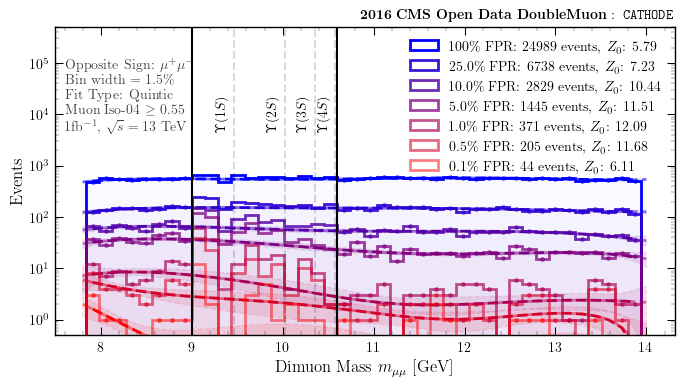

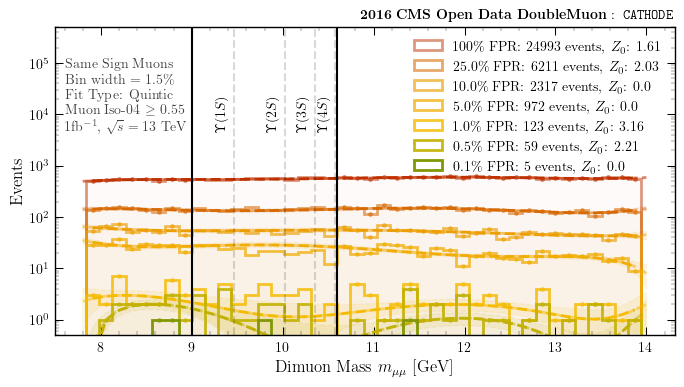

In [106]:


num_points = 7
bsx_c = [((i) * np.power(i, 0), 0 , (1-i) * np.power(i, 0.0)) for i in np.linspace(0, 1, num_points)]
bsx_a = np.linspace(1, 0.5, num_points)

# Red Yellow Green color scheme
# 8ea604-c2b102-f5bb00-f1ad03-ec9f05-d76a03-bf3100
ryg_c = ['#6A7D04', '#758904', "#819704", "#c2b102", "#f5bb00", "#f1ad03", "#ec9f05", "#d76a03", "#bf3100"][::-1]
ryg_a = np.linspace(0.5, 1, num_points)


# Plot the CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    hist_data = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}:\,\,\tt{CATHODE}$", upsilon_lines = True, colors = bsx_c, alphas = bsx_a, line_0 = r"Opposite Sign: $\mu^+\mu^-$")
# apply_color_filter_to_plot(ax, rgb_to_gray)
# apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
plt.savefig(f"plots/histogram_{fit_type}_{num_bins_SR}.pdf")

# Plot the Same Sign CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_alt = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_alt, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}:\,\,\tt{CATHODE}$", upsilon_lines = True, colors = ryg_c, alphas = ryg_a, line_0 = r"Same Sign Muons")
# apply_color_filter_to_plot(ax, rgb_to_gray)
plt.savefig(f"plots/histogram_alt_{fit_type}_{num_bins_SR}.pdf")

# # Plot the individual features
# for feature in feature_set:
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
#         hist_data = pickle.load(file)

#     plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\,(\mu^+\mu^-)}$: " + feature, upsilon_lines = True)


# Significances 

In [100]:
fpr_thresholds_finegrained = np.logspace(-4, 0, 25)[::-1]

feature_sigs = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs["CATHODE"] = pickle.load(file)

dimu_pt: 9.32701040332322
mu0_ip3d: 7.455123621153591
mu1_ip3d: 7.451960819453846
CATHODE: 15.131344088487566
[ 5.78610504  5.52904572  6.78150695  7.58242626  7.38851007 10.61862731
 10.43953771 11.98506246 12.97992941 14.35273106 15.13134409 14.25086059
 12.08563809 11.63434834 10.82564394 10.90569192  9.67201788  7.81991145
  6.11177909  5.23716895  4.63727533  0.          0.          0.
  0.        ]


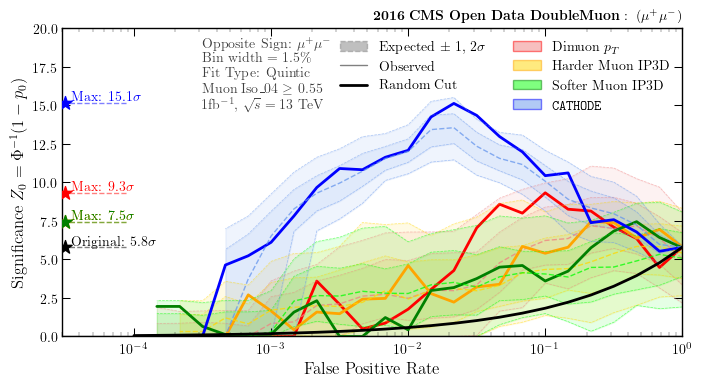

In [110]:
import matplotlib.patches as mpatches

def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("column",width = 8, height = 4)

primary_colors = ["red", "orange", "green", "blue"]
colors = ["lightcoral", "gold", "lime", "cornflowerblue"]


min_x = 3e-5
labels = {"CATHODE" : r"$\texttt{CATHODE}$", "dimu_pt" : "Dimuon $p_T$", "mu0_ip3d" : "Harder Muon IP3D", "mu1_ip3d" : "Softer Muon IP3D"}


# primary_colors = ["red",  "blue"]
# colors = ["lightcoral",  "cornflowerblue"]

for (i, key) in enumerate(feature_sigs.keys()):


    SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_sigs[key][:,1:])
    SIG_observed = feature_sigs[key][:,0]

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = primary_colors[i], lw = 2)

    ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.75)
    ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

    # plot the boundaries with a thin line
    ax.plot(fpr_thresholds_finegrained, SIG_lower, color = colors[i], linestyle = "dashed", alpha = 0.5, lw = 0.5)
    ax.plot(fpr_thresholds_finegrained, SIG_upper, color = colors[i], linestyle = "dashed", alpha = 0.5, lw = 0.5)

    ax.plot(fpr_thresholds_finegrained, SIG_2lower, color = colors[i], linestyle = "dashed", alpha = 0.5, lw = 0.5)
    ax.plot(fpr_thresholds_finegrained, SIG_2upper, color = colors[i], linestyle = "dashed", alpha = 0.5, lw = 0.5)

    # Plot the maximum observed significance
    max_observed = np.nanmax(SIG_observed)
    plt.scatter(min_x*1.05, max_observed, color = primary_colors[i], zorder = 1000, marker="*", s = 100)
    plt.plot([min_x, min_x*3], [max_observed, max_observed], color = primary_colors[i], linestyle = "dashed", alpha = 0.5, lw = 1)
    plt.text(min_x * 1.15, max_observed + 0.35, f"Max: {max_observed:.1f}$\sigma$", color = primary_colors[i], fontsize = 10, verticalalignment = "center")

    print(f"{key}: {max_observed}")



# Artificially make a legend
legend_items = []
l = plt.axhline(0, color = "Grey", label = "Observed")

legend_item = mpatches.Patch(label="Expected $\pm$ 1, 2$\sigma$", edgecolor="Grey", facecolor="Grey", linestyle = "--", alpha = 0.5)
legend_items.append(legend_item)
legend_items.append(l)

lp = ax.plot(fpr_thresholds_finegrained, SIG_median[0]*fpr_thresholds_finegrained/np.sqrt(fpr_thresholds_finegrained), color = "black", label = "Random Cut", lw = 2)
legend_items.append(lp[0])
max_random = np.nanmax(SIG_median[0]*fpr_thresholds_finegrained/np.sqrt(fpr_thresholds_finegrained))
plt.scatter(min_x*1.05, max_random, color = "black", zorder = 1000, marker="*", s = 100)
plt.plot([min_x, min_x*3], [max_random, max_random], color = "black", linestyle = "dashed", alpha = 0.5, lw = 1)
plt.text(min_x * 1.15, max_random + 0.35, f"Original: {max_random:.1f}$\sigma$", color = "black", fontsize = 10, verticalalignment = "center")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_sigs.keys()) 
for i in range(num_features - 3):
    # plt.axhline(0, color = "white", label = " ")
    legend_item = mpatches.Patch(label=" ", edgecolor="white", facecolor="white")
    legend_items.append(legend_item)


# Add the keys in a seperate column with filled color
# legend item is a rectangle with the color of the line
for (i, key) in enumerate(feature_sigs.keys()):
    legend_item = mpatches.Patch(label=labels[key], edgecolor=primary_colors[i], facecolor=colors[i], alpha = 0.5)
    legend_items.append(legend_item)



print(feature_sigs["CATHODE"][:,0])



ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line_0 = r"Opposite Sign: $\mu^+\mu^-$"

    
line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
line2 = f"Fit Type: {fit_type.capitalize()}"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r"1fb$^{-1}$, $\sqrt{s} = 13$ TeV"

starting_x = 0.225
starting_y = 0.925
delta_y = 0.05
text_alpha = 0.75

if line_0 is not None:
    # ax.text(starting_x, starting_y - (-2) * delta_y, "2016 DoubleMuon", transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - (-1) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon:\,\, (\mu^+\mu^-)}$"
plt.legend(handles=legend_items, loc = "upper right", ncol = 2, fontsize = 10)    
plt.title(legend_title, loc = "right", fontsize = 10)


# plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 20)
plt.xlim(min_x, 1)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

plt.savefig(f"plots/significance_{fit_type}_{num_bins_SR}.pdf")



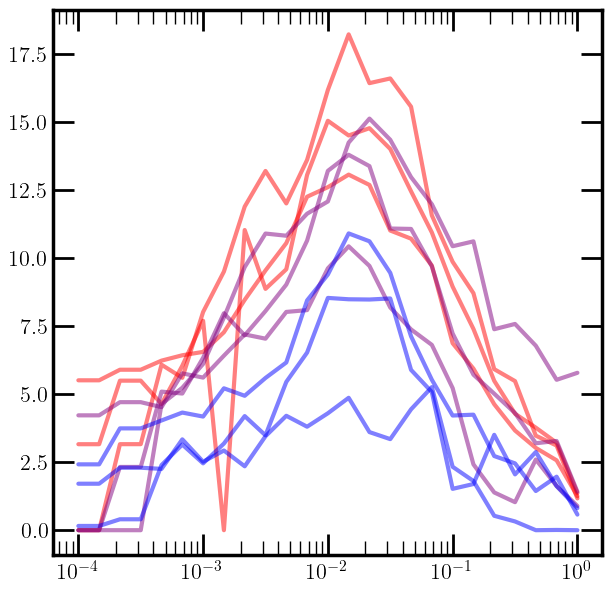

In [102]:
def plot_variations():

    fig, ax = newplot("full")


    fits = ["cubic", "quintic", "septic"]
    colors = ["red", "purple", "blue"]
    bins = [8, 12, 16]

    for i, fit in enumerate(fits):
        for bin in bins:
           with open(f"{plot_data_dir}{data_prefix}_significances_{fit}_{bin}.pickle", "rb") as file:
                sigs = pickle.load(file)

                SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(sigs[:,1:])
                SIG_observed = sigs[:,0]

                ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i], alpha = 0.5)

    plt.xscale("log")
            
plot_variations()